# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [34]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import copy
import pdb
%matplotlib inline


## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


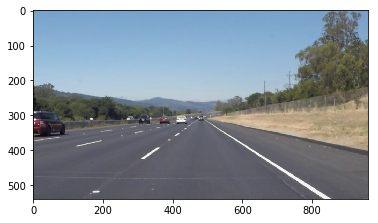

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

# Solution

## Step 1 - Convert to Grayscale

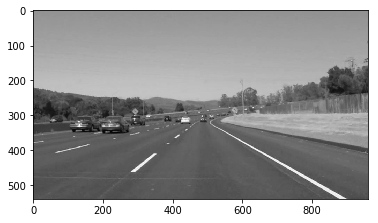

In [47]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray = grayscale(image)
plt.imshow(gray, cmap='gray')

## Step 2 - Apply Gaussian Kernal noise

In [50]:
def gaussian(image):
    kernel_size = 5
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

blur_gray = gaussian(gray)

## Step 3 - Apply Canny edge detection

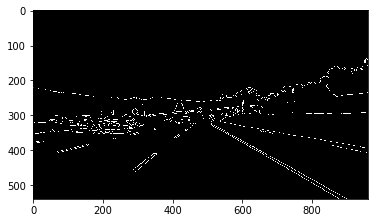

In [51]:
def canny(image):
    low_threshold = 50
    high_threshold = 150
    return cv2.Canny(image, low_threshold, high_threshold)

edges = canny(blur_gray)
plt.imshow(edges, cmap='gray')

## Step 4 - Apply Region masking

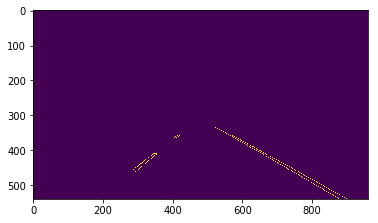

In [53]:
def mask(image):
    # Create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(image)
    # Define a four sided polygon to mask
    imshape = image.shape
    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    vertices = np.array([[(0,imshape[0]),(500, 320), (490, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    return cv2.bitwise_and(image, mask)

masked_edges = mask(edges)
plt.imshow(masked_edges)

## Step 5 - Apply Hough Transform

In [56]:
def hough(image):
    rho = 2                         # distance resolution in pixels of the Hough grid
    theta = np.pi/180               # angular resolution in radians of the Hough grid
    threshold = 19                  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 24            # minimum number of pixels making up a line
    max_line_gap = 20               # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image. Output is an array containing endpoints of detected line segments.
    return cv2.HoughLinesP(image, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

lines = hough(masked_edges)
print(*lines)

[[580 362 898 538]] [[535 341 877 538]] [[389 382 420 356]] [[302 443 347 410]] [[290 463 353 412]] [[576 360 645 399]] [[386 383 418 360]] [[383 381 411 359]] [[295 461 352 412]] [[613 385 781 482]] [[816 504 876 538]] [[322 427 346 410]] [[614 381 897 538]] [[281 462 317 431]]


## Step 6 - Find the left and right lanes

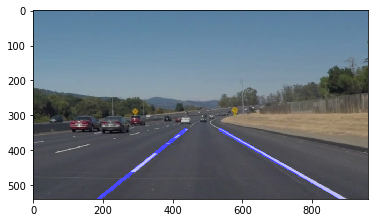

In [57]:
def draw_lanes(lines, image):
    
    lane_image = np.copy(image)*0 #creating a blank to draw lines on
    lane_color = (0,0,255)
    lane_thickness = 10
    
    left_slopes = []
    left_intercepts = []
    
    right_slopes = []
    right_intercepts = []
    
    y_max = image.shape[0]
    y_min = lane_image.shape[0]
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            m, b = np.polyfit((x1, x2), (y1, y2), 1)
            y_min = min(y_min, y1, y2)
            if(m > 0):
                left_slopes.append(m)
                left_intercepts.append(b)
            if(m < 0):
                right_slopes.append(m)
                right_intercepts.append(b)
    
    if len(left_slopes) > 0: 
        # Draw the left lane
        left_slope = np.median(left_slopes)
        left_intercept = np.median(left_intercepts)
        left_x_min = int((y_min-left_intercept)/left_slope)
        left_x_max = int((y_max-left_intercept)/left_slope)
        cv2.line(lane_image, (left_x_min, y_min), (left_x_max, y_max), lane_color, lane_thickness)
    if len(right_slopes) > 0:
        # Draw the right lane
        right_slope = np.median(right_slopes)
        right_intercept = np.median(right_intercepts)
        right_x_min = int((y_min-right_intercept)/right_slope)
        right_x_max = int((y_max-right_intercept)/right_slope)
        cv2.line(lane_image, (right_x_min, y_min), (right_x_max, y_max), lane_color, lane_thickness)
    
    return cv2.addWeighted(image, 0.8, lane_image, 1, 0)

lanes = draw_lanes(lines, image)
plt.imshow(lanes)

## Final Solution/**Pipeline**

In [58]:
def process_image(image):
    gray = grayscale(image)
    filtered = gaussian(gray)
    edges = canny(filtered)
    masked = mask(edges)
    lines = hough(masked)
    
    return draw_lanes(lines, image)

## Run the pipeline through all test images

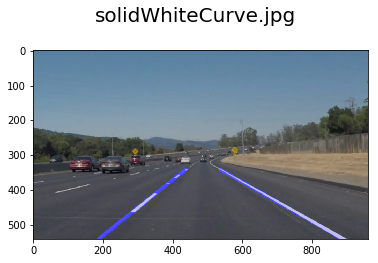

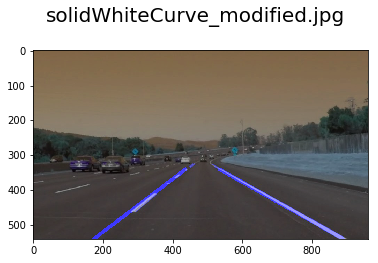

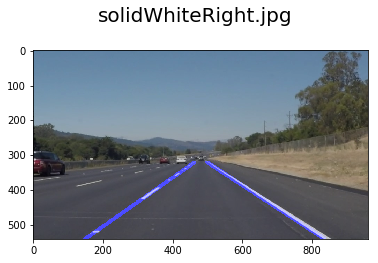

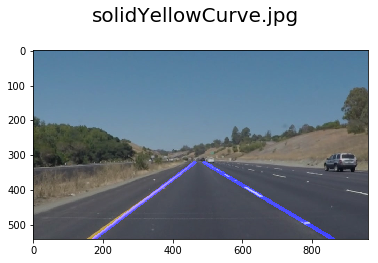

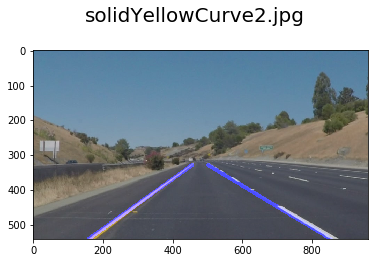

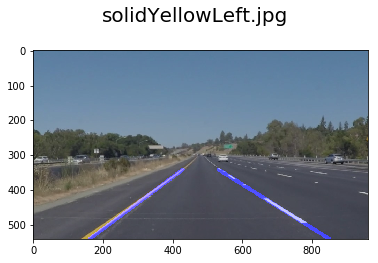

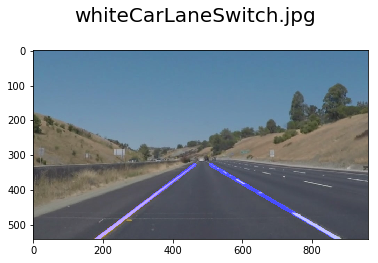

In [59]:
import os

test_images = os.listdir("test_images/")

if not os.path.isdir("test_images_output"):
    os.mkdir("test_images_output")

for i in range(0, len(test_images)):
    # Read image
    img = mpimg.imread(os.path.join("test_images", test_images[i]))
    # Run the pipeline
    img_out = process_image(img)
    # Save output
    mpimg.imsave(os.path.join("results", test_images[i]), img_out)
    # Show output
    plt.figure()
    plt.suptitle(test_images[i], fontsize=20)
    plt.imshow(img_out)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [61]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 33.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 7.56 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [64]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 30.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.5 s


In [65]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))